In [1]:
%cd ~/code/textrec/

/Users/kcarnold/code/textrec


In [2]:
import datetime
import json
import pathlib

import pandas as pd
import numpy as np
import toolz
from IPython.display import Image, HTML

In [16]:
from textrec.paths import paths
from textrec import analysis_util, util, notebook_util, onmt_model_2
reload(analysis_util), reload(util), reload(notebook_util), reload(onmt_model_2)

Loading COCO captions
Loading COCO id2url
Done
Loading ONMT models...
coco_lm_adam_acc_46.00_ppl_16.32_e10_nooptim.pt
Loading model parameters.
coco_cap_adam_acc_48.73_ppl_12.56_e10_nooptim.pt
Loading model parameters.
Ready.


(<module 'textrec.analysis_util' from '/Users/kcarnold/code/textrec/src/textrec/analysis_util.py'>,
 <module 'textrec.util' from '/Users/kcarnold/code/textrec/src/textrec/util.py'>,
 <module 'textrec.notebook_util' from '/Users/kcarnold/code/textrec/src/textrec/notebook_util.py'>,
 <module 'textrec.onmt_model_2' from '/Users/kcarnold/code/textrec/src/textrec/onmt_model_2.py'>)

In [14]:
paths.imgdata_h5 = paths.imgdata_h5_all

/Users/kcarnold/anaconda3/envs/py36/lib/python3.6/site-packages/h5py/__init__.py:36: FutureWarning: Conversion of the second argument of issubdtype from `float` to `np.floating` is deprecated. In future, it will be treated as `np.float64 == np.dtype(float).type`.
  from ._conv import register_converters as _register_converters


Loading ONMT models...
coco_lm_adam_acc_46.00_ppl_16.32_e10_nooptim.pt
Loading model parameters.
coco_cap_adam_acc_48.73_ppl_12.56_e10_nooptim.pt
Loading model parameters.
Ready.


In [29]:
%matplotlib inline
import matplotlib.pyplot as plt

In [10]:
img = notebook_util.images[0]
print(img['cocoid'])
img_captions = [sent['tokens'] for sent in img['sentences']]
print('\n'.join(' '.join(toks) for toks in img_captions))

391895
a man with a red helmet on a small moped on a dirt road
man riding a motor bike on a dirt road on the countryside
a man riding on the back of a motorcycle
a dirt path with a young person on a motor bike rests to the foreground of a verdant area with a bridge and a background of cloud wreathed mountains
a man in a red shirt and a red hat is on a motorcycle on a hill side


In [17]:
onmt_model_2.get_recs('coco_cap', str(img['cocoid']), [])

[('a', -0.19775964319705963),
 ('man', -3.1341943740844727),
 ('the', -3.242462158203125)]

Word-at-a-time ROC curve. TODO: character-at-a-time?

In [33]:
import random

In [34]:
import tqdm

In [40]:
true_contains = []
max_probs = []
mean_probs = []
min_probs = []
for img in tqdm.tqdm_notebook(random.sample(notebook_util.images, 100)):
    sent = random.choice(img['sentences'])
    toks = sent['tokens']
    for tok_idx in range(len(toks)):
        true_word = toks[tok_idx]
        context = toks[:tok_idx]
        recs = onmt_model_2.get_recs('coco_cap', str(img['cocoid']), context)
        probs = [prob for word, prob in recs]
        true_contains.append(true_word in [word for word, prob in recs])
        max_probs.append(max(probs))
        mean_probs.append(np.mean(probs))
        min_probs.append(min(probs))


In [22]:
np.mean(true_contains)

0.7439024390243902

In [36]:
from sklearn.metrics import roc_curve, auc

In [41]:
rocs = {
    k: dict(zip('fpr tpr thresholds'.split(), roc_curve(true_contains, v)))
    for k, v in [('max', max_probs), ('mean', mean_probs), ('min', min_probs)]
}
aucs = {k: auc(roc['fpr'], roc['tpr']) for k, roc in rocs.items()}
# fpr_max, tpr_max, thresholds_max = 
# auc_max = auc(fpr_max, tpr_max)

# fpr_min, tpr_min, thresholds_min = roc_curve(true_contains, min_probs)
# auc_min = auc(fpr_min, tpr_min)

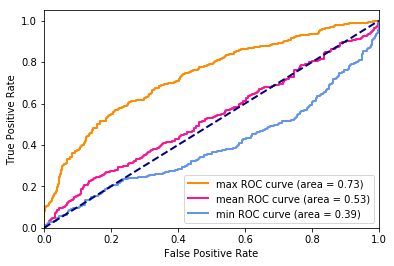

In [44]:
lw = 2
for name, color in [('max', 'darkorange'), ('mean', 'deeppink'), ('min', 'cornflowerblue')]:
    roc = rocs[name]
    plt.plot(roc['fpr'], roc['tpr'], color=color,
             lw=lw, label=f'{name} ROC curve (area = {aucs[name]:.02f})')
plt.plot([0, 1], [0, 1], color='navy', lw=lw, linestyle='--')
plt.xlim([0.0, 1.0])
plt.ylim([0.0, 1.05])
plt.xlabel('False Positive Rate')
plt.ylabel('True Positive Rate')
# plt.title('Receiver operating characteristic example')
plt.legend(loc="lower right")


We should definitely use the max value as the threshold.